In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

c:\Users\araf1\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

c:\Users\araf1\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [11]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

C:\Users\araf1\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: c:\Old Laptop Files\Sentiment Analysis with BERT\apps.csv

  0%|          | 0.00/134k [00:00<?, ?B/s]
100%|██████████| 134k/134k [00:00<00:00, 992kB/s]
100%|██████████| 134k/134k [00:00<00:00, 978kB/s]
C:\Users\araf1\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: c:\Old Laptop Files\Sentiment Analysis with BERT\reviews.csv

  0%|          | 0.00/7.17M [00:00<?, ?B/s]
  7%

In [13]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [14]:
df.shape

(15746, 11)

In [15]:
df.info

<bound method DataFrame.info of                 userName                                          userImage  \
0          Andrew Thomas  https://lh3.googleusercontent.com/a-/AOh14GiHd...   
1           Craig Haines  https://lh3.googleusercontent.com/-hoe0kwSJgPQ...   
2          steven adkins  https://lh3.googleusercontent.com/a-/AOh14GiXw...   
3       Lars Panzerbjørn  https://lh3.googleusercontent.com/a-/AOh14Gg-h...   
4          Scott Prewitt  https://lh3.googleusercontent.com/-K-X1-YsVd6U...   
...                  ...                                                ...   
15741          Tammy Kay  https://lh3.googleusercontent.com/a-/AOh14GhYP...   
15742          Ysm Johan  https://lh3.googleusercontent.com/a-/AOh14Ggmd...   
15743      casey dearden  https://lh3.googleusercontent.com/a-/AOh14Gg2U...   
15744     Jerry G Tamate  https://lh3.googleusercontent.com/a-/AOh14GiTP...   
15745  Ahmed elsalamouni  https://lh3.googleusercontent.com/-9QSxVUhCoDI...   

                   

In [16]:
df.columns

Index(['userName', 'userImage', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'sortOrder',
       'appId'],
      dtype='object')

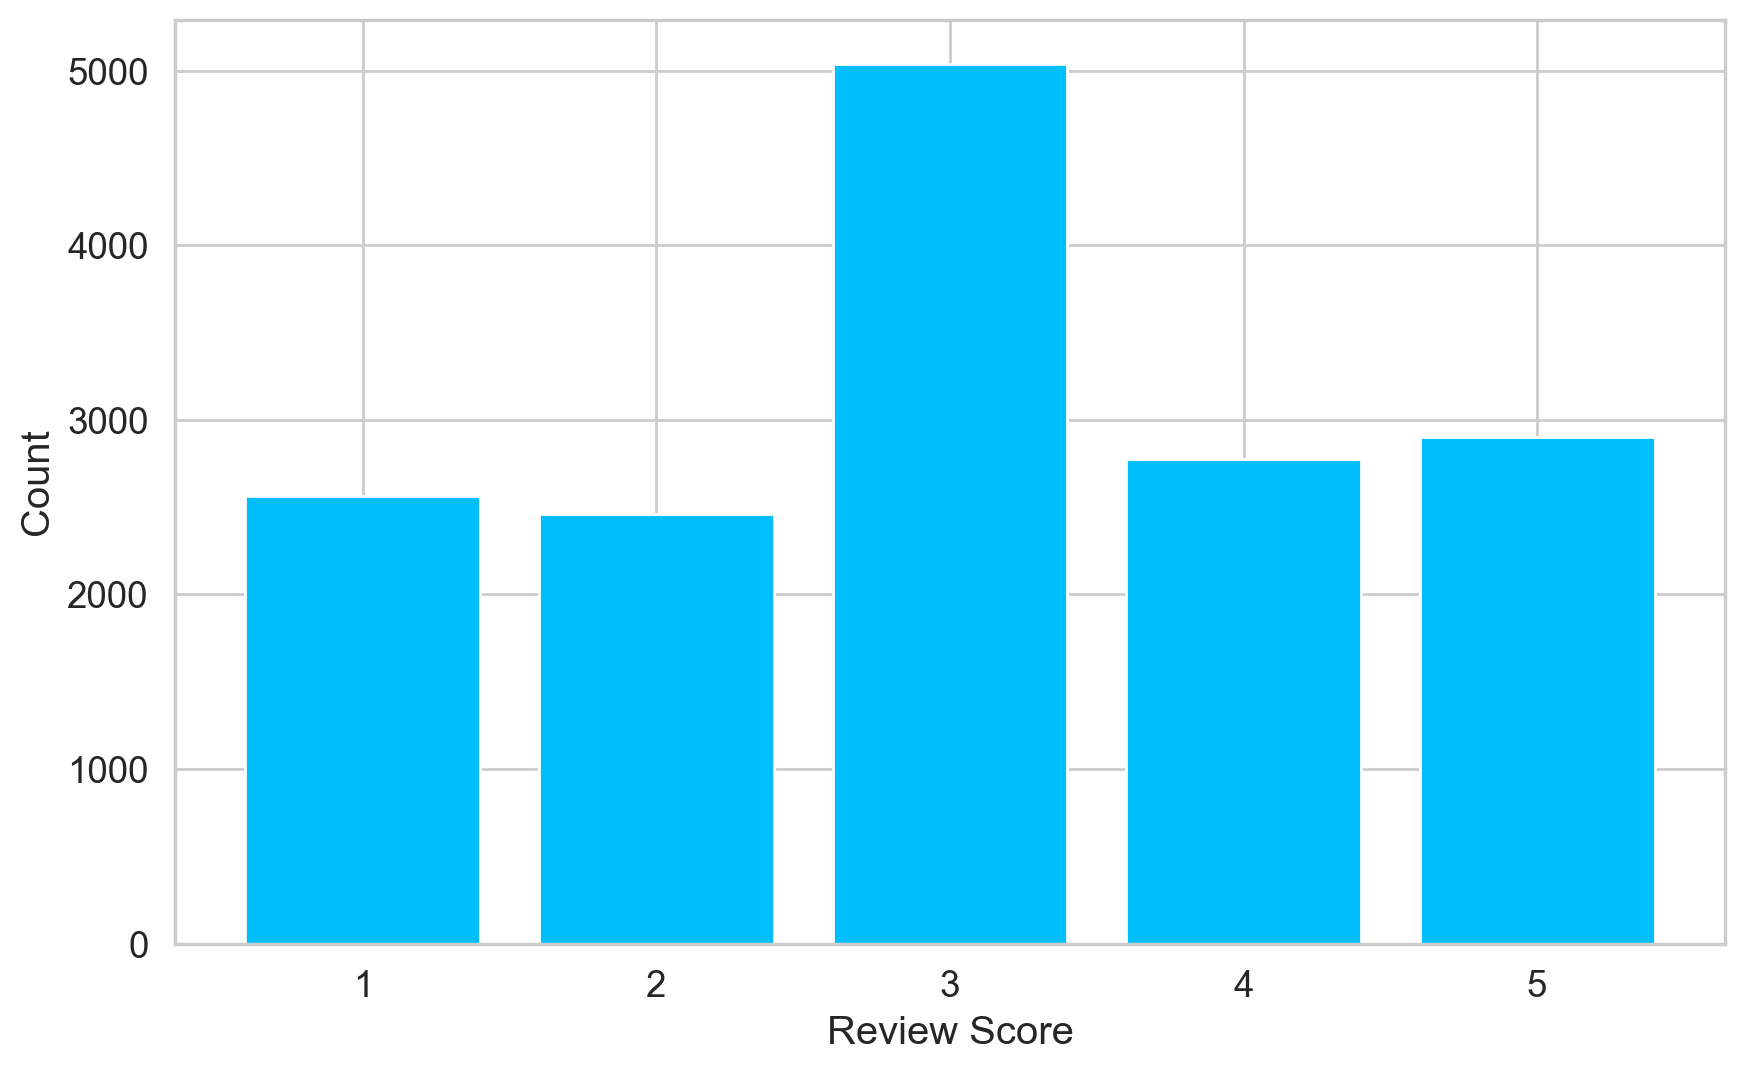

In [17]:
# without any advanced scaling

plt.figure(figsize=(10, 6))
plt.bar(df['score'].value_counts().index, df['score'].value_counts().values)
plt.xlabel('Review Score')
plt.ylabel('Count')

plt.tight_layout
plt.show()

In [18]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [19]:
class_names = ['negative', 'neutral', 'positive']

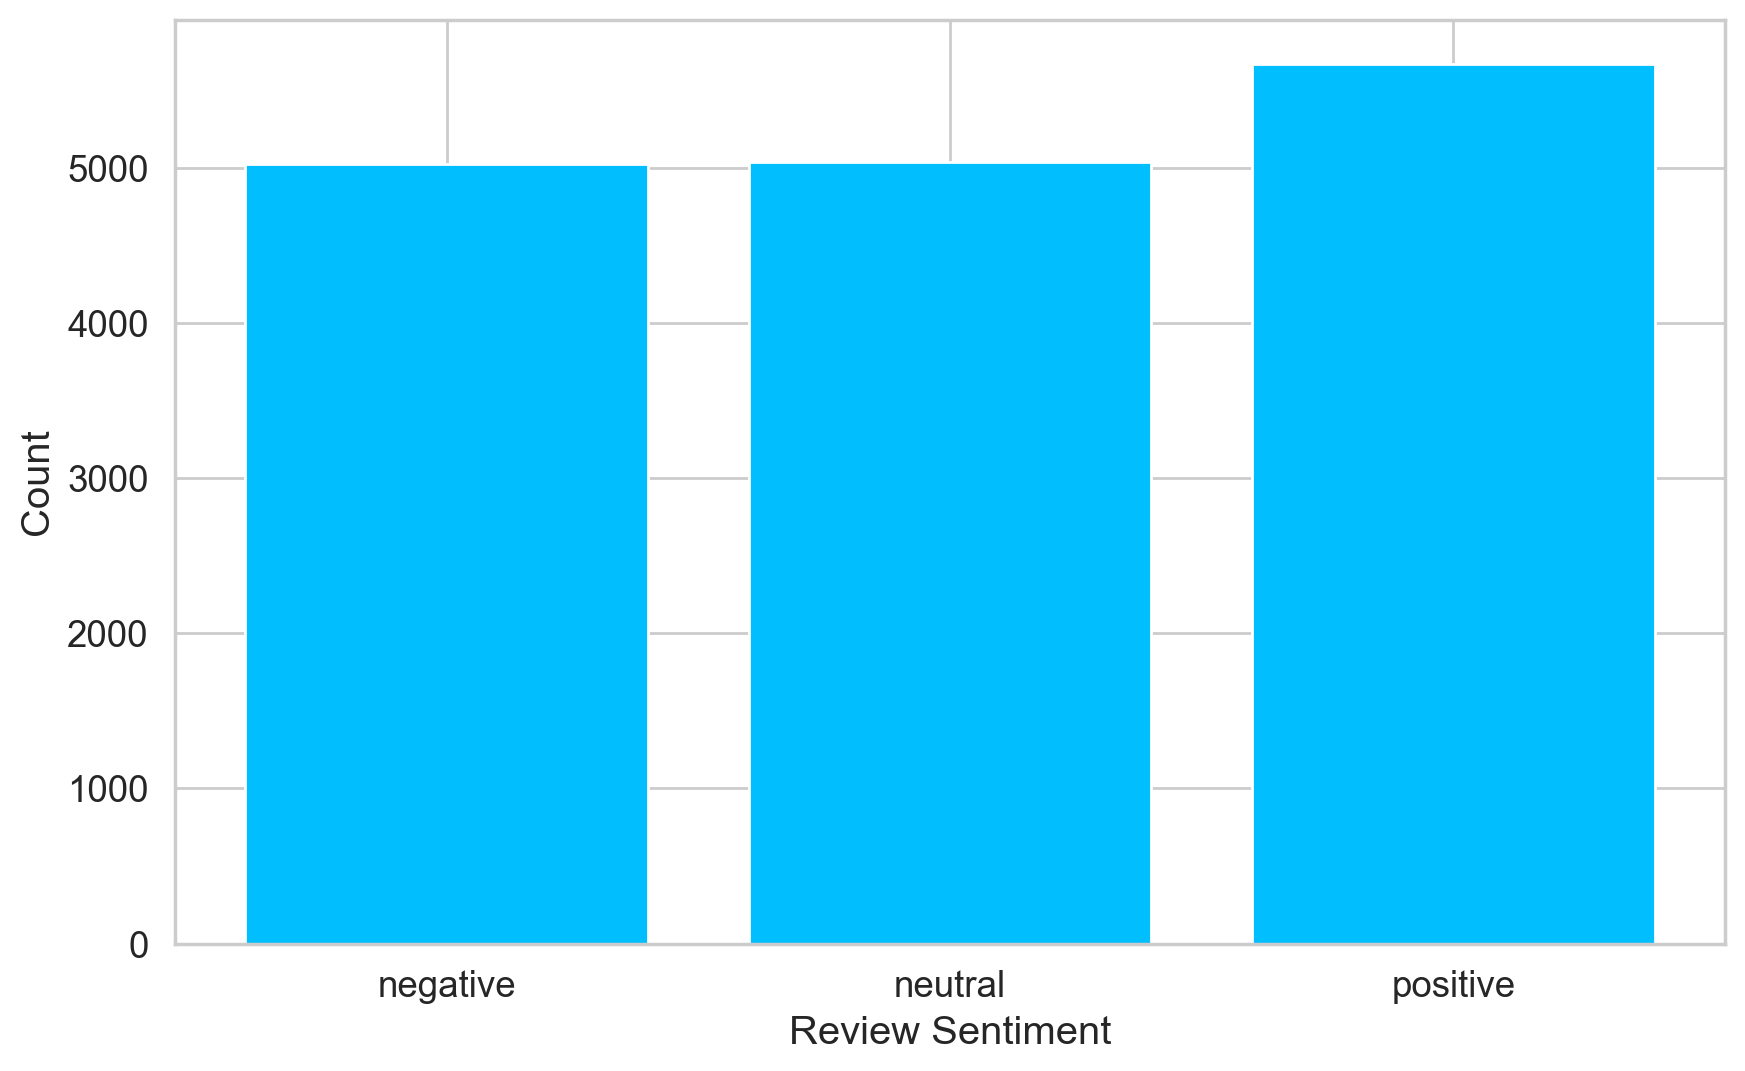

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(df['sentiment'].value_counts().index, df['sentiment'].value_counts().values)
plt.xticks(ticks=[0, 1, 2], labels=class_names)

plt.xlabel('Review Sentiment')
plt.ylabel('Count')

plt.tight_layout
plt.show()

In [21]:
pretrained_model_name = 'bert-base-cased'

In [22]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

In [23]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks'

In [24]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_text}')
print(f'tokens: {tokens}')
print(f'token_ids: {token_ids}')

Sentence: When was I last outside? I am stuck at home for 2 weeks
tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']
token_ids: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277]


In [25]:
bert_model = BertModel.from_pretrained(pretrained_model_name)

In [26]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [27]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [28]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [29]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [30]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\araf1\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [32]:
encoding['input_ids'][0]

tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [33]:
encoding['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [35]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

C:\Users\araf1\AppData\Local\Temp\ipykernel_32128\1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


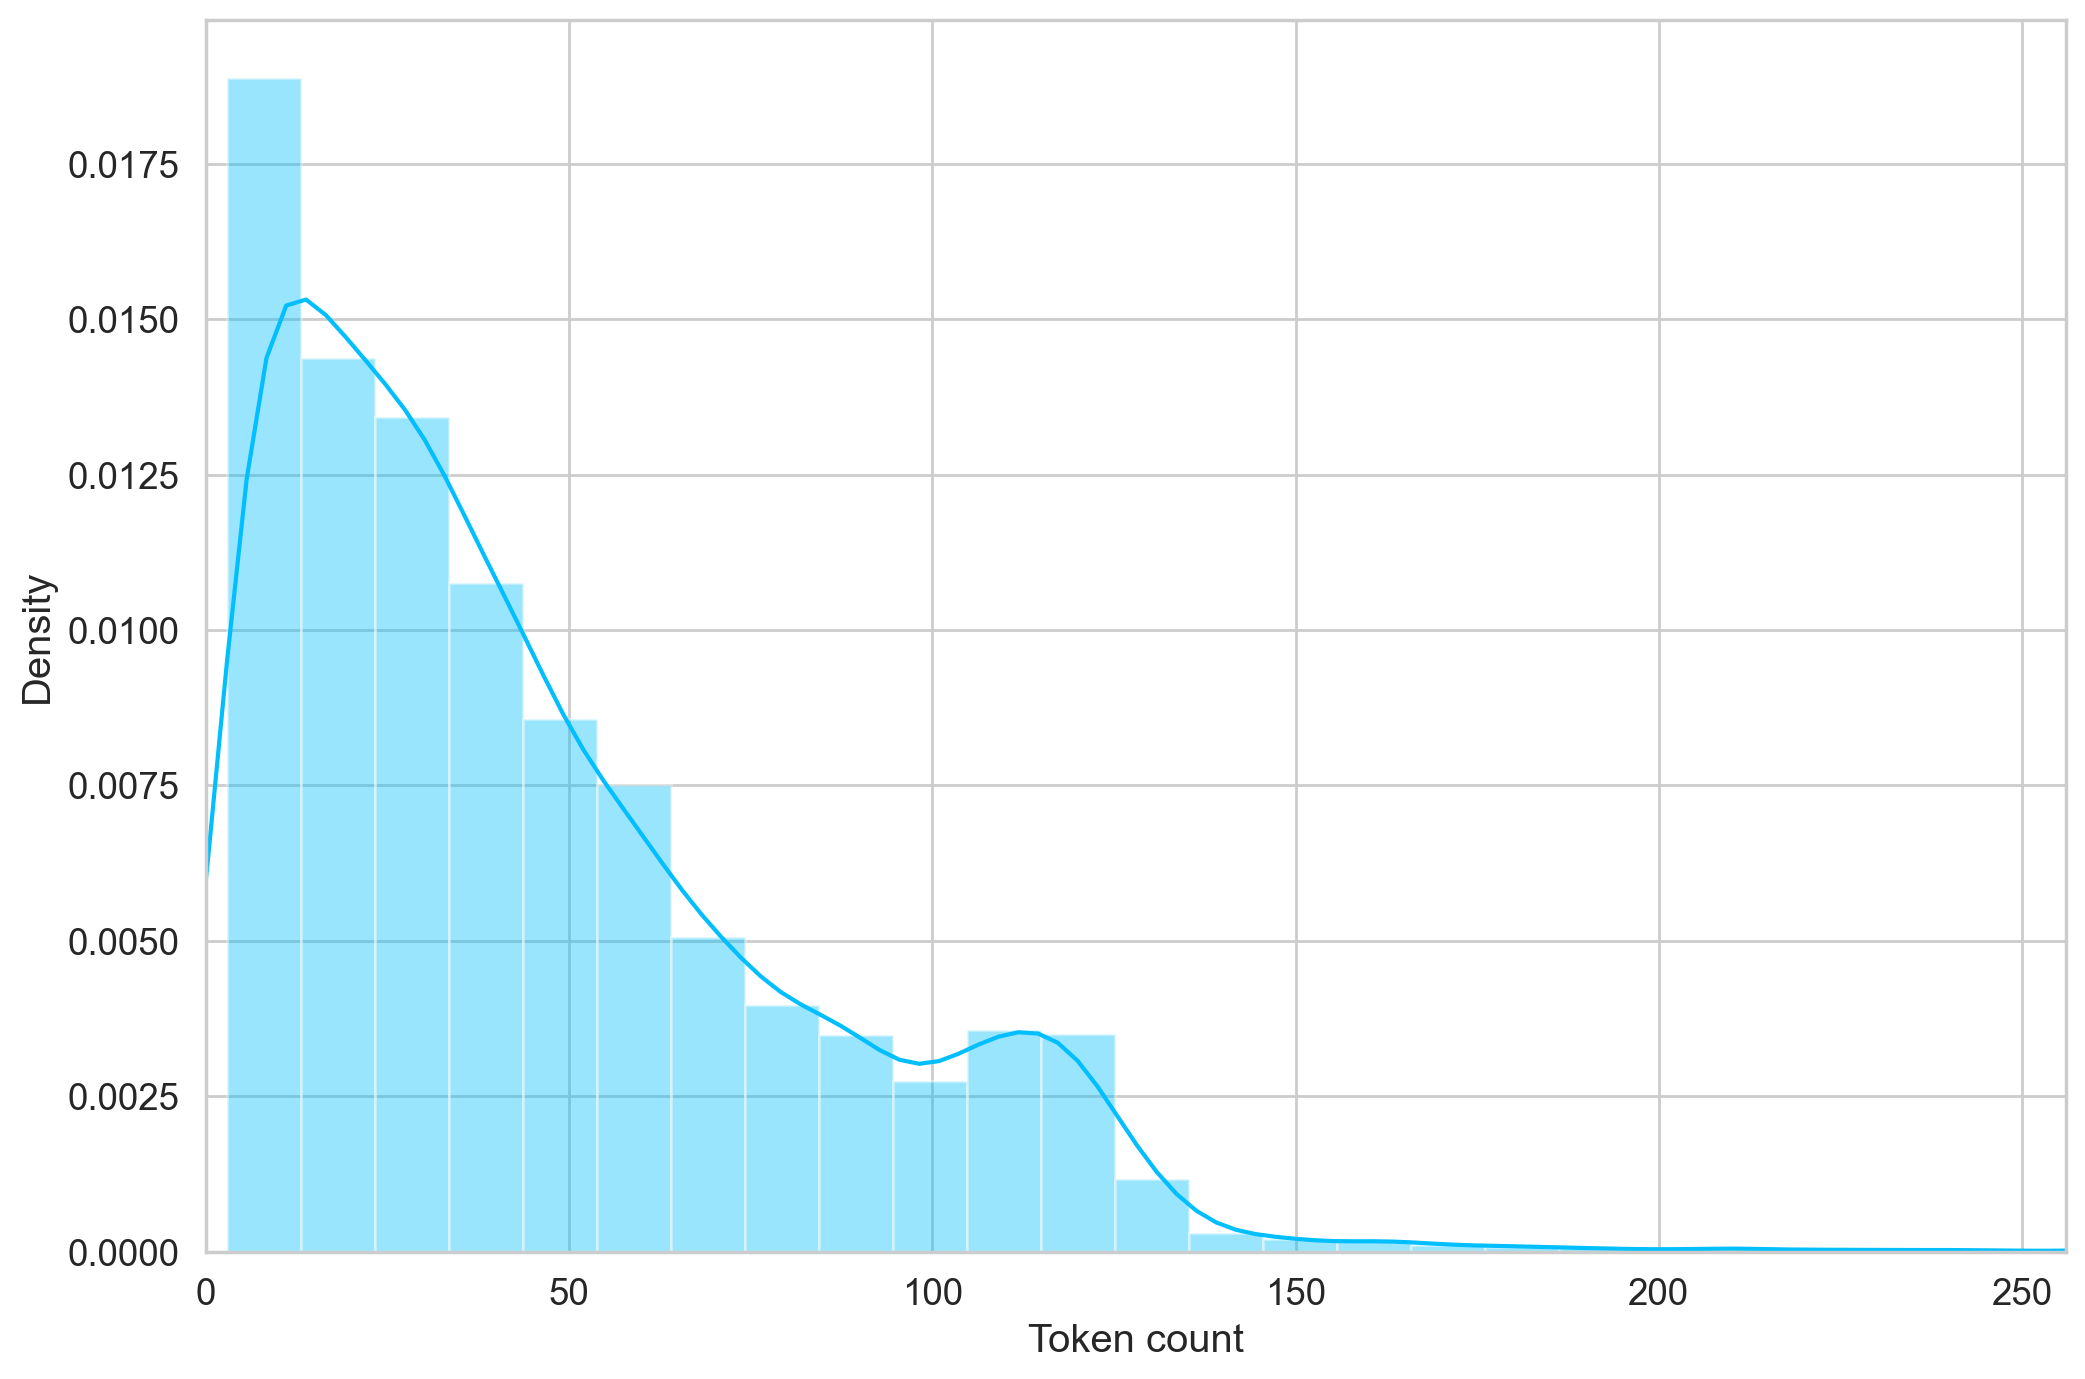

In [36]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [37]:
MAX_LEN = 160

In [38]:
class dataset_for_sentiment(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [39]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [40]:
df_train.shape, df_test.shape, df_val.shape

((14171, 12), (788, 12), (787, 12))

In [41]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = dataset_for_sentiment(
        reviews = df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(
        ds,
        batch_size = batch_size
    )

In [42]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [43]:
train_data_loader

In [44]:
data = next(iter(train_data_loader))
data.keys()

C:\Users\araf1\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [45]:
data

{'review_text': ["You can't have your to do list as notifications",
  "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.",
  '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.',
  'Love it so far. Wish it had a widget for Android though.',
  "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way 

In [46]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [47]:
bert_model = BertModel.from_pretrained(pretrained_model_name)

In [48]:
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [49]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.4108,  0.2013, -0.2184,  ...,  0.0233,  0.2054, -0.0579],
         [-0.4271, -0.4274,  0.0975,  ..., -0.0237,  0.2866, -0.1025],
         [-0.1509,  0.0418, -0.5138,  ...,  0.7618, -0.2684,  0.7717],
         ...,
         [ 0.1969,  0.3800, -0.2471,  ...,  0.0281, -0.0408,  0.1150],
         [ 0.2386,  0.3005,  0.1105,  ..., -0.2427, -0.0428, -0.0344],
         [ 0.0659,  0.2417,  0.0322,  ...,  0.0609,  0.1704, -0.1551]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-6.9729e-01,  4.4131e-01,  9.9986e-01, -9.9429e-01,  9.5898e-01,
          9.4832e-01,  9.8312e-01, -9.8957e-01, -9.6531e-01, -6.1933e-01,
          9.7893e-01,  9.9866e-01, -9.9790e-01, -9.9980e-01,  7.2519e-01,
         -9.7932e-01,  9.8686e-01, -4.8770e-01, -9.9996e-01, -7.3112e-01,
         -2.4581e-01, -9.9988e-01,  2.4964e-01,  9.7877e-01,  9.6561e-01,
          6.3478e-02,  9.8399e-01,  9.9996e-01,  7.8640e-01, -5.537

In [50]:
last_hidden_state = output['last_hidden_state']

In [51]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [52]:
pooled_output = output['pooler_output']

In [53]:
pooled_output.shape

torch.Size([1, 768])

In [54]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        pooled_output = output['pooler_output']
        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [55]:
model = SentimentClassifier(len(class_names))

In [56]:
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [57]:
device

'cpu'

In [58]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [59]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2163, 0.2670, 0.5168],
        [0.1766, 0.4226, 0.4008],
        [0.3120, 0.1996, 0.4885],
        [0.2469, 0.2678, 0.4853],
        [0.3467, 0.1845, 0.4688],
        [0.3030, 0.3014, 0.3955],
        [0.1367, 0.1952, 0.6681],
        [0.2218, 0.3431, 0.4350],
        [0.1742, 0.1546, 0.6712],
        [0.2514, 0.3557, 0.3929],
        [0.2129, 0.2929, 0.4942],
        [0.3048, 0.2559, 0.4393],
        [0.1992, 0.3696, 0.4312],
        [0.2954, 0.2578, 0.4468],
        [0.2770, 0.1434, 0.5796],
        [0.2587, 0.2117, 0.5297]], grad_fn=<SoftmaxBackward0>)

In [60]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias=False)
total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\araf1\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [61]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):


    model.train()
    losses = []
    correct_predictions = 0

    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    return correct_predictions.double() / n_examples, np.mean(losses)




In [62]:
def eval_mode(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask
                            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_mode(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/10
----------
Train loss 0.7352101212497758 accuracy 0.6715122433138099
Val   loss 0.5635308021306992 accuracy 0.770012706480305


 10%|█         | 1/10 [06:29<58:26, 389.59s/it]

Epoch 2/10
----------
Train loss 0.4418624166575834 accuracy 0.8318396725707431
Val   loss 0.5218805985152721 accuracy 0.8259212198221093


 20%|██        | 2/10 [12:59<51:58, 389.79s/it]

Epoch 3/10
----------
Train loss 0.25908630231498375 accuracy 0.9151083198080587
Val   loss 0.6220925156772137 accuracy 0.843710292249047


 30%|███       | 3/10 [19:28<45:26, 389.54s/it]

Epoch 4/10
----------
Train loss 0.18076495458931677 accuracy 0.9479923788017783
Val   loss 0.6825999913783743 accuracy 0.8691232528589581


 40%|████      | 4/10 [25:58<38:58, 389.79s/it]

Epoch 5/10
----------
Train loss 0.1454478553660544 accuracy 0.9593536094841578


 50%|█████     | 5/10 [32:22<32:17, 387.56s/it]

Val   loss 0.7206140818912536 accuracy 0.8653113087674714
Epoch 6/10
----------
Train loss 0.11154774973525311 accuracy 0.9685272740103028


 60%|██████    | 6/10 [38:45<25:44, 386.10s/it]

Val   loss 0.7427290774183348 accuracy 0.8576874205844981
Epoch 7/10
----------
Train loss 0.10043130040450077 accuracy 0.9727612730223697
Val   loss 0.7181517938198522 accuracy 0.8792884371029225


 70%|███████   | 7/10 [45:12<19:19, 386.41s/it]

Epoch 8/10
----------
Train loss 0.09705406417850769 accuracy 0.9732552395737775


 80%|████████  | 8/10 [51:36<12:50, 385.41s/it]

Val   loss 0.7537180019641528 accuracy 0.8792884371029225
Epoch 9/10
----------
Train loss 0.09547611920935765 accuracy 0.9751605391292075


 90%|█████████ | 9/10 [57:59<06:24, 384.75s/it]

Val   loss 0.8535792143677827 accuracy 0.8703939008894537
Epoch 10/10
----------
Train loss 0.077947224508247 accuracy 0.9786183049890622


100%|██████████| 10/10 [1:04:22<00:00, 386.29s/it]

Val   loss 0.9346566170910955 accuracy 0.866581956797967


In [63]:
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))

C:\Users\araf1\AppData\Local\Temp\ipykernel_32128\3166881386.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin', map

<All keys matched successfully>

In [ ]:
test_acc, _ = eval_mode(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

In [68]:
test_acc.item()

0.8705583756345178

In [69]:
def get_predictions(model, data_loader):
    
    model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    return review_texts, predictions, prediction_probs, real_values
    

In [70]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

C:\Users\araf1\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [71]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.84      0.87       245
     neutral       0.82      0.83      0.83       254
    positive       0.89      0.93      0.91       289

    accuracy                           0.87       788
   macro avg       0.87      0.87      0.87       788
weighted avg       0.87      0.87      0.87       788



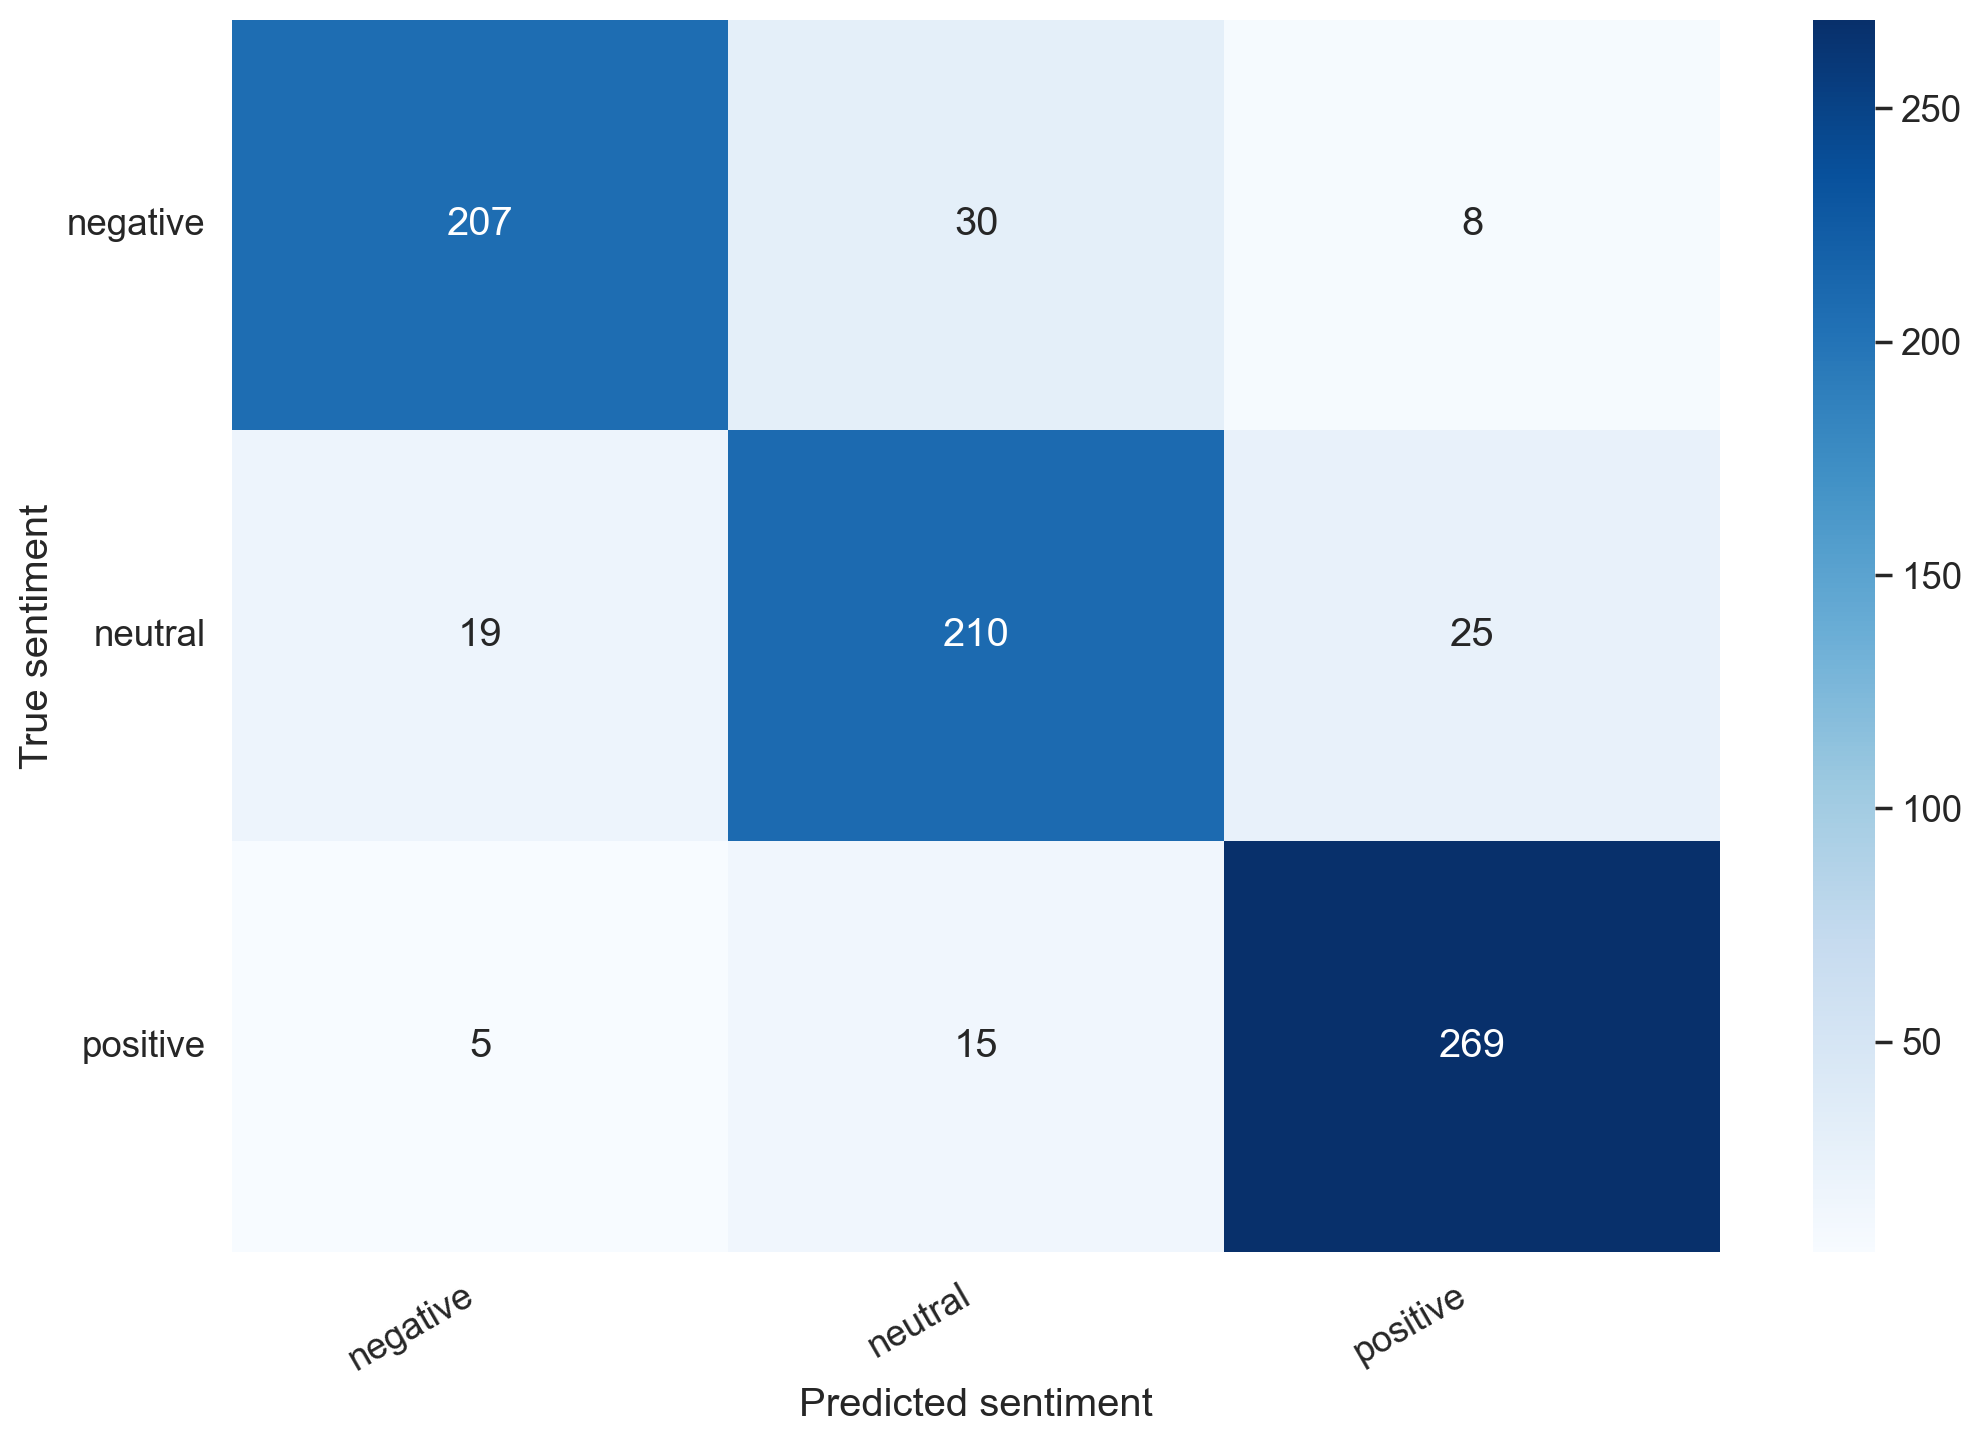

In [72]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [75]:
raw_text = "I am optimistic about my preparation. I believe I will do very good in the exam"

encoded_review = tokenizer.encode_plus(
    raw_text,
    max_length = MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

C:\Users\araf1\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [76]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {raw_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: fuck this shit, I don't feel fucking good anymore
Sentiment  : negative
